In [1]:
import UWGeodynamics as GEO
import numpy as np
from underworld import function as fn
import glucifer
from MechanicalProperties import PlateProperties
from ModelGeometry import SubductionCreator,interpolateTracer,rmRepeated,fuseListM,ListToNd

loaded rc file /usr/local/lib/python3.5/dist-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
#Units
u = GEO.UnitRegistry
#Rebecca et al., Scaling
dRho =   80. * u.kilogram / u.meter**3 # matprop.ref_density
g    =   9.8 * u.meter / u.second**2   # modprop.gravity
H    = 800. * u.kilometer #  modprop.boxHeight-- OR 840 dependig if I include the sticky air layer

# lithostatic pressure for mass-time-length
ref_stress = dRho * g * H
# viscosity of upper mante for mass-time-length
ref_viscosity = 1e20 * u.pascal * u.seconds
#References
ref_time        = ref_viscosity/ref_stress
ref_length      = H
ref_mass        = (ref_viscosity*ref_length*ref_time)
#ref_temperature = modprop.Tint - modprop.Tsurf

KL = ref_length       
KM = ref_mass         
Kt = ref_time
#KT = ref_temperature

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
#GEO.scaling_coefficients["[temperature]"] = KT

In [3]:
#Model Dimensions
Model = GEO.Model(elementRes=(296,160), #296,160 #296,128, #120,64
                  minCoord=(-1800. * u.kilometer, -800.0 * u.kilometer), 
                  maxCoord=(1800. * u.kilometer, 0.0 * u.kilometer),
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

#Model Output Folder
Model.outputDir = "outputs_MechanicalTransference_BenchmarkFinal_32kmArc_80Ma_DruckerPrager_WLM"


In [4]:
#need to find an expression to calculate the length of decoupling layer in function of resolution....the minimum working
#value to quickly achieve subduction without overlubricate the subduction zone

In [5]:
#Model Geometry 
#Decoupling Layer- 70 Km for 296, for 120, 110
DipAngle=30
DipLen=300
#SubductionCreator(Model,y0,thickness, dipAngle, dipLength, maxLength, orientation, SLayers,OLayers, ExLens,bStrips,tD=False)
geometry=SubductionCreator(Model,0,100,DipAngle,DipLen,2400,-1,4,2,(210,210,210,210),(40,40,40,40),(True,True, True, True),0.)
xcoords = GEO.uw.function.input()[0]
ycoords = GEO.uw.function.input()[1]
#Model limits
orientation=geometry[6][0]
xlimit=GEO.nd(geometry[6][1])
#cratLim=GEO.nd(geometry[8][2])

In [6]:
#PlateProperties(Nlayers,crustThickness,crustDensity,mantleDensity,plateThickness,oceanic,age, cohesion,friction,arc,arcDensity,arcThickness,depthToMantle)
#Oceanic Plate
data1=PlateProperties(4,7.,2900.,3400.,100.,True,80.,12.5,12.5,0.066,0.033,False,0.,0.,100.,2.)
#Cratonic continental - Values can be +5MPa!!
data2=PlateProperties(2,40.,2700.,3400.,150.,False,80.,15.,10.,0.15,0.08,False,0.,0.,150.,.2)
#Back-arc
data3=PlateProperties(2,20.,2800.,3400.,100.,False,80.,10.,7.5,0.005,0.0035,False,0.,0.,80.,2.) #the last specifies how much was extended the lithosphere
#Arc Crust
data4=PlateProperties(4,7.,2900.,3400.,100.,True,80.,12.5,12.5,0.066,0.033,True,2838.,32.,100.,2.)
#eclogite-Properties
data5=PlateProperties(4,7.,3500.,3400.,100.,True,80.,12.5,12.5,0.066,0.033,False,0.,0.,100.,2.)

/usr/local/lib/python3.5/dist-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


In [7]:
#Densities without units 
refD=3400.0 * u.kilogram / u.metre**3 #Mantle Density
#(Subducting plate)
l1d=data1[2][0]* u.kilogram / u.metre**3 
l2d=data1[2][1]* u.kilogram / u.metre**3 
l3d=data1[2][2]* u.kilogram / u.metre**3 
l4d=data1[2][3]* u.kilogram / u.metre**3 
#Cratonic overriding plate
cl1=data2[2][0]* u.kilogram / u.metre**3 
cl2=data2[2][1]* u.kilogram / u.metre**3 
#Back-Arc overriding plate
bl1=data3[2][0]* u.kilogram / u.metre**3 
bl2=data3[2][1]* u.kilogram / u.metre**3 
#Arc density
al1=data4[2][0]* u.kilogram / u.metre**3 
al2=data4[2][1]* u.kilogram / u.metre**3 
#Oceanic crust to Eclogite
e1d=data5[2][0]* u.kilogram / u.metre**3
#Lower Mantle density - 1.6 +-1 to 5+-2 percentage the upper mantle density - (1.6+7)/2/100 - 3400.+(3400*0.043)
LMdensity=3546.2* u.kilogram / u.metre**3

In [8]:
## Calculate Geometry
#SubductionCreator(Model,y0,thickness, dipAngle, dipLength, maxLength, orientation, SLayers,OLayers, ExLens,bStrips,tD=False)
#return subducting,overriding, weak,arc,bstop
#Materials in the model
#stickyAir=Model.add_material(name="StickyAir", shape=GEO.shapes.Layer(top=40.*u.kilometer, bottom=0.*u.kilometer))
UMantle =Model.add_material(name="UpperMantle", shape=GEO.shapes.Layer(top=0.*u.kilometer, bottom=-660.*u.kilometer))
#stickyAir = Model.add_material(name="Air", shape=GEO.shapes.Layer(top=Model.top, bottom=0. * u.kilometer))
LMantle=Model.add_material(name="LowerMantle", shape=GEO.shapes.Layer(top=-660.*u.kilometer, bottom=Model.bottom))
#OLithosphere1D = Model.add_material(name="SubductingPlateL1", shape=geometry[0][0][0])
#OLithosphere2D=Model.add_material(name="SubductingPlateL2", shape=geometry[0][0][1])
#OLithosphere3D=Model.add_material(name="SubductingPlateL3", shape=geometry[0][0][2])
#OLithosphere4D=Model.add_material(name="SubductingPlateL4", shape=geometry[0][0][3])
OLithosphere1F = Model.add_material(name="SubductingPlateL1", shape=geometry[0][2][0])
OLithosphere2F=Model.add_material(name="SubductingPlateL2", shape=geometry[0][2][1])
OLithosphere3F=Model.add_material(name="SubductingPlateL3", shape=geometry[0][2][2])
OLithosphere4F=Model.add_material(name="SubductingPlateL4", shape=geometry[0][2][3])
Clithosphere1= Model.add_material(name="Overriding plate Crust", shape=geometry[1][0])
Clithosphere2= Model.add_material(name="Overriding plate Lithosphere", shape=geometry[1][1])
Clithosphereweak1=Model.add_material(name="Overriding plate Weak Crust", shape=geometry[2][0])
Clithosphereweak2=Model.add_material(name="Overriding plate Weak Lithosphere", shape=geometry[2][1])
# decoup1= Model.add_material(name="Decoupling", shape=geometry[4][0])
# decoup2= Model.add_material(name="Decoupling", shape=geometry[4][1])
# decoup3= Model.add_material(name="Decoupling", shape=geometry[4][2])
# decoup4= Model.add_material(name="Decoupling", shape=geometry[4][3])
#backstop1=Model.add_material(name="Back Stop", shape=geometry[4][0])
#backstop2=Model.add_material(name="Back Stop", shape=geometry[4][1])
#backstop3=Model.add_material(name="Back Stop", shape=geometry[4][2])
#backstop4=Model.add_material(name="Back Stop", shape=geometry[4][3])
OArc1=Model.add_material(name="IntraOceanicArc", shape=geometry[3][0])
OArc2=Model.add_material(name="IntraOceanicArc", shape=geometry[3][1])
# sg11=Model.add_material(name="Weakness1", shape=geometry[5][0])
# sg12=Model.add_material(name="Weakness2", shape=geometry[5][1])
# sg13=Model.add_material(name="Weakness3", shape=geometry[5][2])
# sg14=Model.add_material(name="Weakness4", shape=geometry[5][3])

In [9]:
# #Eclogite material
# eclogite=Model.add_material(name="EclogiteTrans")
# #Orogenic wedge material
# #Owedge=Model.add_material(name="Orogen Material"))


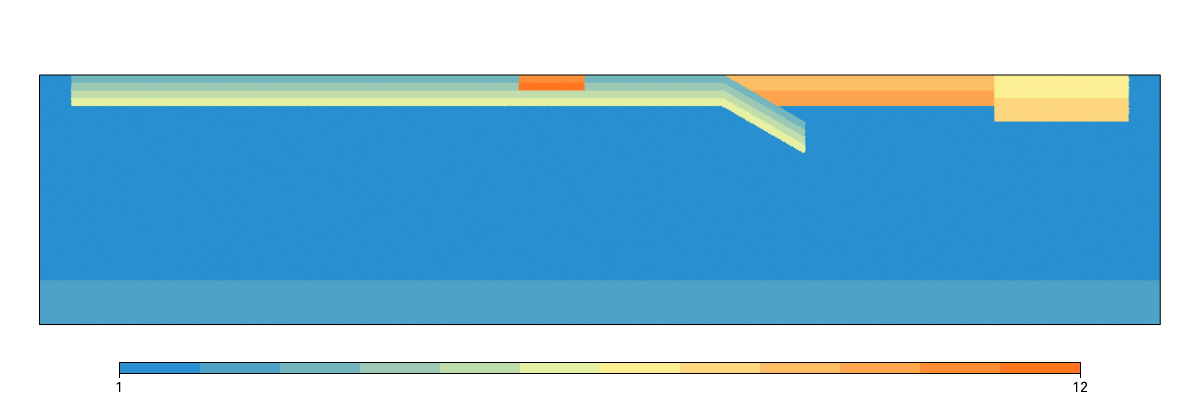

In [10]:
#Preview of 2D materials-Materials Field (from swarm)
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, Model.materialField,fn_size=2.0, discrete=True)
#Fig.Surface(Model.mesh,Model.projMaterialField,fn_size=2.0)
Fig.show()

In [11]:
#Lateral Change in density or not in this model.
LateralChange=False
if LateralChange==True:
    fac=1.
else:
    fac=0.

#Parameters
if orientation==1:
    SPdelta = (GEO.nd(Model.maxCoord[0])-(GEO.nd(xlimit)) - (GEO.nd(100 * u.kilometer)))
elif orientation==-1:
    SPdelta = (GEO.nd(Model.minCoord[0])-(GEO.nd(xlimit)) + (GEO.nd(100 * u.kilometer)))
#Conditions for both orientations

if orientation==1:
    c5="xcoords < xlimit"
elif orientation==-1:
    c5="xcoords > xlimit"
#If orientation =1
conditionsL=[(geometry[0][1][0],(fac*(GEO.nd((refD-l1d))/SPdelta)*(fn.math.abs(GEO.nd(xcoords-(xlimit)))))+GEO.nd(l1d)),
            (geometry[0][1][1],(fac*(GEO.nd((refD-l2d))/SPdelta)*(fn.math.abs(GEO.nd(xcoords-(xlimit)))))+GEO.nd(l2d)),
            (geometry[0][1][2],(fac*(GEO.nd((refD-l3d))/SPdelta)*(fn.math.abs(GEO.nd(xcoords-(xlimit)))))+GEO.nd(l3d)),
            (geometry[0][1][3],(fac*(GEO.nd((refD-l4d))/SPdelta)*(fn.math.abs(GEO.nd(xcoords-(xlimit)))))+GEO.nd(l4d)),
            (geometry[0][0][0],GEO.nd(l1d)),
            (geometry[0][0][1],(GEO.nd((l2d)))),
            (geometry[0][0][2],(GEO.nd((l3d)))),
            (geometry[0][0][3],(GEO.nd((l4d)))),
             (Model.y > GEO.nd(-660.*u.kilometer),GEO.nd(refD)),
            (True,GEO.nd(LMdensity))]

#If orientation =-1

conditionsR=[(geometry[0][1][0],(fac*(GEO.nd((refD-l1d))/SPdelta)*((GEO.nd(xcoords-(xlimit)))))+GEO.nd(l1d)),
            (geometry[0][1][1],(fac*(GEO.nd((refD-l2d))/SPdelta)*((GEO.nd(xcoords-(xlimit)))))+GEO.nd(l2d)),
            (geometry[0][1][2],(fac*(GEO.nd((refD-l3d))/SPdelta)*((GEO.nd(xcoords-(xlimit)))))+GEO.nd(l3d)),
            (geometry[0][1][3],(fac*(GEO.nd((refD-l4d))/SPdelta)*((GEO.nd(xcoords-(xlimit)))))+GEO.nd(l4d)),
            (geometry[0][0][0],GEO.nd(l1d)),
            (geometry[0][0][1],(GEO.nd((l2d)))),
            (geometry[0][0][2],(GEO.nd((l3d)))),
            (geometry[0][0][3],(GEO.nd((l4d)))),
            (Model.y > GEO.nd(-660.*u.kilometer),GEO.nd(refD)),
            (True,GEO.nd(LMdensity))]

if orientation==1:
    conditionsD=conditionsL
elif orientation==-1:
    conditionsD=conditionsR


RoFn =  fn.branching.conditional(conditionsD)
RoField=GEO.uw.swarm.SwarmVariable(Model.swarm,dataType="double",count=1)
RoField.data[:]=RoFn.evaluate(Model.swarm)


In [12]:
#Eclogitization parametrization
conditions=[(Model.y > GEO.nd(-150.*u.kilometer),RoField),
            (True,GEO.nd(e1d)),
    
]
eclogiteFn=fn.branching.conditional(conditions)

In [13]:
## Density- Includes relative density calculation for arc
#stickyAir.density = 100. * u.kilogram / u.metre**3
UMantle.density = RoField
LMantle.density = RoField 
OLithosphere1F.density =eclogiteFn
OLithosphere2F.density =RoField
OLithosphere3F.density =RoField
OLithosphere4F.density =RoField
Clithosphere1.density=cl1  
Clithosphere2.density=cl2
Clithosphereweak1.density=bl1 
Clithosphereweak2.density=bl2
OArc1.density=al1 
OArc2.density=al2 

/usr/local/lib/python3.5/dist-packages/UWGeodynamics/__init__.py:83: UserWarning: 'Dimensionalize' has been changed to 'dimensionalise', please use the later
  warnings.warn("""'Dimensionalize' has been changed to 'dimensionalise', please use the later""")



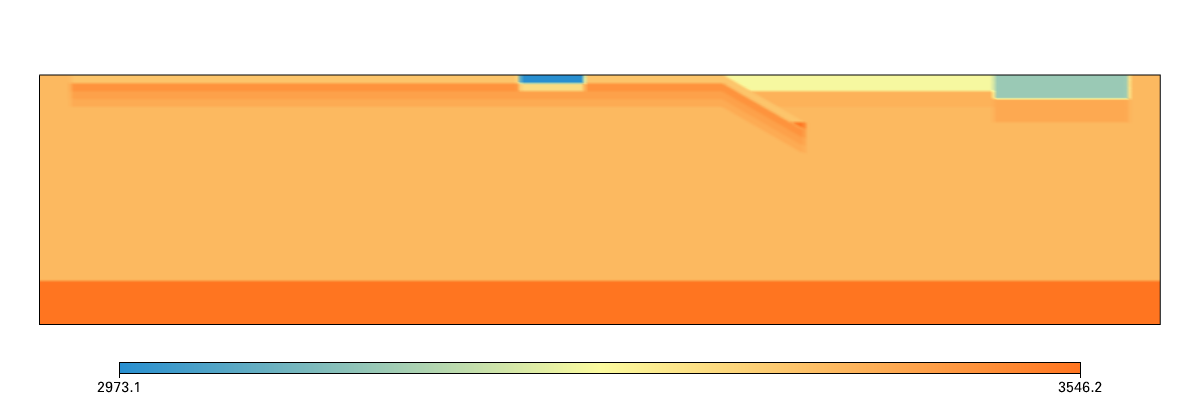

In [14]:
#Density Field
Fig = glucifer.Figure(figsize=(1200,400))
#Fig.Points(Model.swarm, GEO.Dimensionalize(Model.densityField, u.kilogram / u.metre**3))
Fig.Surface(Model.mesh, GEO.Dimensionalize(Model.projDensityField, u.kilogram / u.metre**3))
Fig.show()

In [15]:
#Viscosities without units 
refV=1e20 #UMantle as reference Viscosity
#(Subducting plate)
vl1d=data1[3][0]
vl2d=data1[3][1]
vl3d=data1[3][2]
vl4d=data1[3][3]
#Cratonic overriding plate
vcl1=data2[3][0]
vcl2=data2[3][1]
#Back-Arc overriding plate
vbl1=data3[3][0]
vbl2=data3[3][1]
#Arc viscosity -- Consider what discussed in Len & Gurnis, 2015 (lower-middle crust is very weak)
val1=data4[3][0]
val2=data4[3][1]
# #Eclogite viscosity
# ve1=data5[3][0]

In [16]:
#stickyAir.viscosity=1e19 * u.pascal * u.second
Model.minViscosity=refV * u.pascal * u.second
UMantle.viscosity =  refV * u.pascal * u.second#UMantle as reference Viscosity
LMantle.viscosity =  30*refV* u.pascal * u.second
#OLithosphere1D.viscosity = 1e5*refV * u.pascal * u.second
#OLithosphere2D.viscosity = 1e5*refV* u.pascal * u.second
#OLithosphere3D.viscosity = 1.93*10**(4)*refV* u.pascal * u.second
#OLithosphere4D.viscosity = 9.64*10**(1)*refV* u.pascal * u.second
OLithosphere1F.viscosity = vl1d* u.pascal * u.second
OLithosphere2F.viscosity = vl2d* u.pascal * u.second
OLithosphere3F.viscosity = vl3d* u.pascal * u.second
OLithosphere4F.viscosity = vl4d* u.pascal * u.second
Clithosphere1.viscosity= vcl1 * u.pascal * u.second
Clithosphere2.viscosity= vcl2 *u.pascal * u.second
Clithosphereweak1.viscosity= vbl1 * u.pascal * u.second
Clithosphereweak2.viscosity= vbl2* u.pascal * u.second#
# decoup1.viscosity= 10**(0)*vbl1 * u.pascal * u.second
# decoup2.viscosity= 10**(0)*vbl1* u.pascal * u.second #
# decoup3.viscosity= 10**(0)*vbl2* u.pascal * u.second #
# decoup4.viscosity= 10**(0)*vbl2* u.pascal * u.second 
#backstop1.viscosity=1e25* u.pascal * u.second
#backstop2.viscosity=1e25* u.pascal * u.second
#backstop3.viscosity=1e25* u.pascal * u.second
#backstop4.viscosity=1e25* u.pascal * u.second
# sg11.viscosity= 10**(-2)*vl1d* u.pascal * u.second
# sg12.viscosity= 10**(-2)*vl2d* u.pascal * u.second
# sg13.viscosity=10**(-2)*vl3d* u.pascal * u.second
# sg14.viscosity=10**(-1)*vl4d* u.pascal * u.second
OArc1.viscosity= val1 * u.pascal * u.second
OArc2.viscosity= val2* u.pascal * u.second 
# eclogite.viscosity=refV *(10**(2))* u.pascal * u.second


In [17]:
#MinViscosity for materials
OLithosphere1F.minViscosity =10**(21) * u.pascal * u.second
OLithosphere2F.minViscosity = 10**(21) * u.pascal * u.second
OLithosphere3F.minViscosity = 10**(21) * u.pascal * u.second
OLithosphere4F.minViscosity = 10**(21) * u.pascal * u.second
Clithosphereweak1.minViscosity= 10**(21) * u.pascal * u.second
Clithosphereweak2.minViscosity=10**(21) * u.pascal * u.second


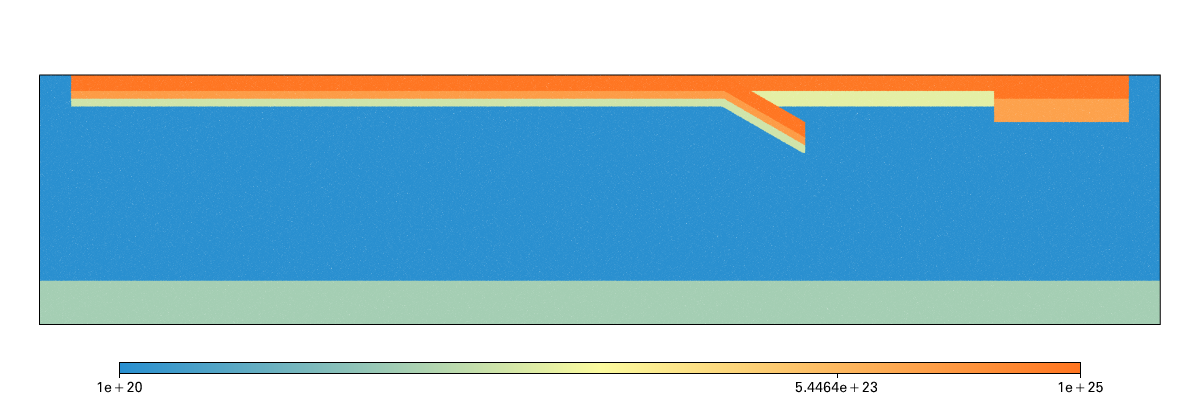

In [18]:
#Viscosity Field
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, GEO.Dimensionalize(Model.viscosityField, u.pascal * u.second),logScale=True)
Fig.show()

In [19]:
#Plasticity- Mechanical Strength
weakSP=True #4,5,6,7 -(4,5) (6,7)
weakOP=True
#(Subducting plate)
if weakSP==True:
    pl1d=(data1[6][0],data1[7][0])
    pl2d=(data1[6][1],data1[7][1])
    pl3d=(data1[6][2],data1[7][2])
    pl4d=(data1[6][3],data1[7][3])
else:
    pl1d=(data1[4][0],data1[7][0])
    pl2d=(data1[4][1],data1[7][1])
    pl3d=(data1[4][2],data1[7][2])
    pl4d=(data1[4][3],data1[7][3])
#Cratonic overriding plate
if weakOP==True:
    pcl1=(data2[4][0],data2[5][0])
    pcl2=(data2[4][1],data2[5][1])
else:
    pcl1=(data2[4][0],data2[5][0])
    pcl2=(data2[4][1],data2[5][1])
#Back-Arc overriding plate
if weakOP==True:
    pbl1=(data3[4][0],data3[5][0])
    pbl2=(data3[4][1],data3[5][1])
else:
    pbl1=(data3[6][0],data3[7][0])
    pbl2=(data3[6][1],data3[7][1])
#Arc Plasticity -- Consider what discussed in Len & Gurnis, 2015 (lower-middle crust is very weak)
if weakSP==True:
    pal1=(data4[6][0],data4[7][0])
    pal2=(data4[6][1],data4[7][1])
else:
    pal1=(data4[4][0],data4[5][0])
    pal2=(data4[4][1],data4[5][1])

In [20]:
# Drucker-Prager-
OLithosphere1F.plasticity = GEO.DruckerPrager(cohesion=12.5 * u.megapascal,
                                            frictionCoefficient=0.008,
                                              #cohesionAfterSoftening=12.5/2. * u.megapascal,
                                              frictionAfterSoftening=0.00001, #Serpentinization (shallow 25 Km)
                                             epsilon1=0.0, 
                                             epsilon2=0.2)
OLithosphere2F.plasticity = GEO.DruckerPrager(cohesion=12.5 * u.megapascal,
                                              frictionCoefficient=0.008,
                                              cohesionAfterSoftening=12.5/2. * u.megapascal,
                                              frictionAfterSoftening=0.0045, #to 0.0035 ? from 0.0027
                                             epsilon1=0.0,
                                             epsilon2=0.2)
OLithosphere3F.plasticity =GEO.DruckerPrager(cohesion=12.5 * u.megapascal,
                                             frictionCoefficient= 0.01,
                                             cohesionAfterSoftening=12.5/2. * u.megapascal,
                                             frictionAfterSoftening=0.0065,
                                            epsilon1=0.0,
                                            epsilon2=0.2)
# OLithosphere4F.plasticity =GEO.VonMises(cohesion=pl4d[0] * u.megapascal,
#                                              cohesionAfterSoftening=pl4d[1] * u.megapascal,
#                                             epsilon1=0.0,
#                                             epsilon2=0.2)
Clithosphere1.plasticity =GEO.DruckerPrager(cohesion=15. * u.megapascal,  #Mean from Lower and Upper from Rey et al., 2014
                                            frictionCoefficient=0.08,
                                       cohesionAfterSoftening=15./2. * u.megapascal, 
                                       frictionAfterSoftening=0.05,
                                            epsilon1=0.0, epsilon2=0.2)
Clithosphere2.plasticity = GEO.DruckerPrager(cohesion=10. * u.megapascal, 
                                             frictionCoefficient=0.08, #Mean from Lower and Upper from Rey et al., 2014
                                       cohesionAfterSoftening=5. * u.megapascal, 
                                       frictionAfterSoftening=0.05, 
                                             epsilon1=0.0, epsilon2=0.2)
Clithosphereweak1.plasticity = GEO.DruckerPrager(cohesion=15. * u.megapascal,
                                                 frictionCoefficient=0.0055,#Mean from Lower and Upper from Rey et al., 2014
                                       cohesionAfterSoftening=4. * u.megapascal,
                                                 frictionAfterSoftening=0.00001,
                                                 epsilon1=0.0, epsilon2=0.2)
Clithosphereweak2.plasticity = GEO.DruckerPrager(cohesion=10. * u.megapascal, 
                                                 frictionCoefficient=0.0045,#Mean from Lower and Upper from Rey et al., 2014
                                       cohesionAfterSoftening=3.5 * u.megapascal, 
                                                 frictionAfterSoftening=0.0015,
                                                epsilon1=0.0, epsilon2=0.2)   #Friction to zero due to weakening (Patrice personal and Len & Gurnis, 2015)    
OArc1.plasticity = GEO.DruckerPrager(cohesion=12.5 * u.megapascal,
                                            frictionCoefficient=0.008,
                                              #cohesionAfterSoftening=12.5/2. * u.megapascal,
                                              frictionAfterSoftening=0.00001, #Serpentinization (shallow 25 Km)
                                             epsilon1=0.0,
                                             epsilon2=0.20)
OArc2.plasticity = GEO.DruckerPrager(cohesion=12.5 * u.megapascal,
                                            frictionCoefficient=0.008,
                                              cohesionAfterSoftening=12.5/6. * u.megapascal,
                                              frictionAfterSoftening=0.00001, #Serpentinization (shallow 25 Km)
                                             epsilon1=0.0,
                                             epsilon2=0.20)
# decoup1.plasticity=GEO.DruckerPrager(cohesion=10/4. * u.megapascal,
#                                                  frictionCoefficient=0.0,#Mean from Lower and Upper from Rey et al., 2014
#                                        cohesionAfterSoftening=0.6 * u.megapascal,
#                                                  #frictionAfterSoftening=0.001,
#                                                  epsilon1=0.0, epsilon2=0.01)
# decoup2.plasticity=GEO.DruckerPrager(cohesion=10/4. * u.megapascal,
#                                                  frictionCoefficient=0.0,#Mean from Lower and Upper from Rey et al., 2014
#                                        cohesionAfterSoftening=0.6 * u.megapascal,
#                                                  #frictionAfterSoftening=0.001,
#                                                  epsilon1=0.0, epsilon2=0.01)
# decoup3.plasticity= GEO.DruckerPrager(cohesion=7.5/4. * u.megapascal, 
#                                                  frictionCoefficient=0.0,#Mean from Lower and Upper from Rey et al., 2014
#                                        cohesionAfterSoftening=0.6 * u.megapascal, 
#                                                  #frictionAfterSoftening=0.002,
#                                                 epsilon1=0.0, epsilon2=0.01)   
# decoup4.plasticity= GEO.DruckerPrager(cohesion=7.5/4. * u.megapascal, 
#                                                  frictionCoefficient=0.0,#Mean from Lower and Upper from Rey et al., 2014
#                                        cohesionAfterSoftening=0.6 * u.megapascal, 
#                                                  #frictionAfterSoftening=0.002,
#                                                 epsilon1=0.0, epsilon2=0.01)  
# sg11.plasticity = GEO.VonMises(cohesion=pal1[0]/4. * u.megapascal,
#                                               cohesionAfterSoftening=pal1[1] * u.megapascal,
#                                              epsilon1=0.0,
#                                              epsilon2=0.2)
# sg12.plasticity = GEO.VonMises(cohesion=pal2[0]/4. * u.megapascal,
#                                               cohesionAfterSoftening=pal2[1] * u.megapascal,
#                                              epsilon1=0.0,
#                                              epsilon2=0.2)
# sg13.plasticity =GEO.VonMises(cohesion=pl3d[0]/4. * u.megapascal,
#                                              cohesionAfterSoftening=pl3d[1] * u.megapascal,
#                                             epsilon1=0.0,
#                                             epsilon2=0.2)
# sg14.plasticity =GEO.VonMises(cohesion=pl4d[0]/4. * u.megapascal,
#                                              cohesionAfterSoftening=pl4d[1] * u.megapascal,
#                                             epsilon1=0.0,
#                                             epsilon2=0.2)


In [21]:
# #Passive Tracers- To track plate convergence/retreat rates
SPTracersC=rmRepeated(geometry[7])
OPTracersC=rmRepeated(geometry[8])
ArcTracersC=rmRepeated(geometry[9])
CratonTracersC=rmRepeated(geometry[10])
#Map for vertexes
SPMap=[(0,1),(1,2),(5,4),(4,3),(8,7),(7,6),(11,10),(10,9),(14,13),(13,12)]
# FlatMap=[(0,1),(5,4),(8,7),(11,10),(14,13)]
# DipMap=[(1,2),(4,3),(7,6),(10,9),(13,12)]
OPMap=[(0,1),(2,3),(4,5)]
ArcMap=[(0,1),(2,3),(4,5)]
CratMap=[(0,1),(2,3),(4,5)]

SP=[]
wise=0
for i in SPMap:
    if wise==0:
        npoints=500
        wise=1
    else:
        npoints=100
    aux=i
    SP.append(interpolateTracer([SPTracersC[0][aux[0]],SPTracersC[1][aux[0]]],
                         
                         [SPTracersC[0][aux[1]],SPTracersC[1][aux[1]]],400)) 
OP=[]
aux=OPMap[0]
OP.append(interpolateTracer([OPTracersC[0][aux[0]],OPTracersC[1][aux[0]]],
                         
                         [OPTracersC[0][aux[1]],OPTracersC[1][aux[1]]],400))
aux=OPMap[1]
OP.append(interpolateTracer([OPTracersC[0][aux[0]],OPTracersC[1][aux[0]]],
                         
                         [OPTracersC[0][aux[1]],OPTracersC[1][aux[1]]],400))
aux=OPMap[2]
OP.append(interpolateTracer([OPTracersC[0][aux[0]],OPTracersC[1][aux[0]]],
                         
                         [OPTracersC[0][aux[1]],OPTracersC[1][aux[1]]],400))
OP_Crat=[]
aux=CratMap[0]
OP_Crat.append(interpolateTracer([CratonTracersC[0][aux[0]],CratonTracersC[1][aux[0]]],
                         
                         [CratonTracersC[0][aux[1]],CratonTracersC[1][aux[1]]],400))
aux=CratMap[1]
OP_Crat.append(interpolateTracer([CratonTracersC[0][aux[0]],CratonTracersC[1][aux[0]]],
                         
                         [CratonTracersC[0][aux[1]],CratonTracersC[1][aux[1]]],400))
aux=CratMap[2]
OP_Crat.append(interpolateTracer([CratonTracersC[0][aux[0]],CratonTracersC[1][aux[0]]],
                         
                         [CratonTracersC[0][aux[1]],CratonTracersC[1][aux[1]]],400))

ArcT=[]
aux=ArcMap[0]
ArcT.append(interpolateTracer([ArcTracersC[0][aux[0]],ArcTracersC[1][aux[0]]],
                         
                         [ArcTracersC[0][aux[1]],ArcTracersC[1][aux[1]]],200))
aux=ArcMap[1]
ArcT.append(interpolateTracer([ArcTracersC[0][aux[0]],ArcTracersC[1][aux[0]]],
                         
                         [ArcTracersC[0][aux[1]],ArcTracersC[1][aux[1]]],200))

aux=ArcMap[2]
ArcT.append(interpolateTracer([ArcTracersC[0][aux[0]],ArcTracersC[1][aux[0]]],
                         
                         [ArcTracersC[0][aux[1]],ArcTracersC[1][aux[1]]],200))
#Fusing Data
# SP_F=fuseListM([SP_F[0],SP_F[1],SP_F[2],SP_F[3],SP_F[4]])
SP=fuseListM([SP[0],SP[1],SP[2],SP[3],SP[4],SP[5],SP[6],SP[7]])
OP=fuseListM([OP[0],OP[1],OP[2]])
ArcT=fuseListM([ArcT[0],ArcT[1],ArcT[2]])
CratonT=fuseListM([OP_Crat[0],OP_Crat[1],OP_Crat[2]])

In [22]:
# SP_FlatTracers = Model.add_passive_tracers(name="SPTracers_flat",vertices=[ListToNd(SP_F[0]),ListToNd(SP_F[1])])
SPTracers = Model.add_passive_tracers(name="SPTracers",vertices=[ListToNd(SP[0]),ListToNd(SP[1])])
OPTracers = Model.add_passive_tracers(name="OPTracers",vertices=[ListToNd(OP[0]),ListToNd(OP[1])])
ArcTracers= Model.add_passive_tracers(name="ArcTracers",vertices=[ListToNd((ArcT[0])),ListToNd((ArcT[1]))])
CratonTracers=Model.add_passive_tracers(name="CratonTracers",vertices=[ListToNd((CratonT[0])),ListToNd((CratonT[1]))])


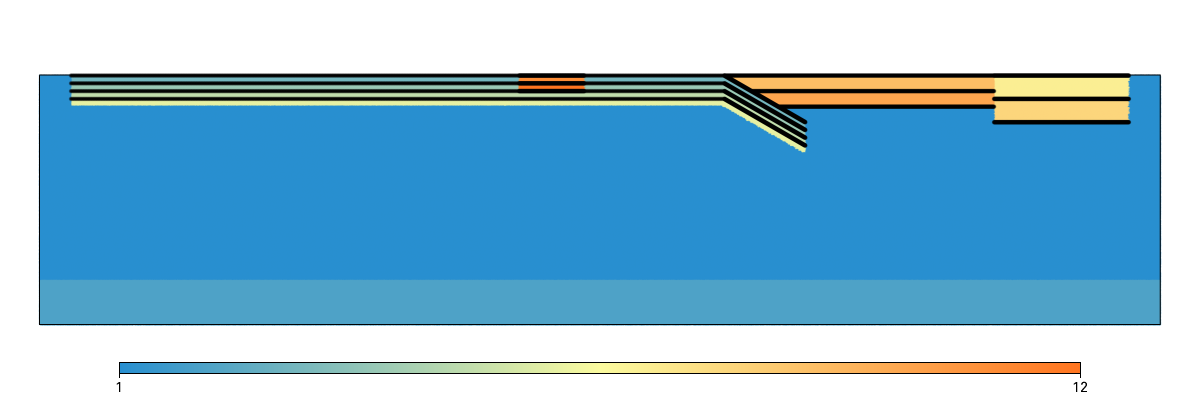

In [23]:
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Points(SPTracers, pointSize=5.0)
Fig.Points(OPTracers, pointSize=5.0)
Fig.Points(ArcTracers, pointSize=5.0)
Fig.Points(CratonTracers, pointSize=5.0)
Fig.Points(Model.swarm, Model.materialField, fn_size=3.0)
Fig.show()

In [24]:
#Fields to Record
#Fields to Record

SPTracers.add_tracked_field(Model.velocityField[0],
                              name="Subducting plate velocity_X",
                              units=u.centimeter/ u.year,
                              dataType="float")
SPTracers.add_tracked_field(Model.velocityField[1],
                              name="Subducting plate velocity_Y",
                              units=u.centimeter/ u.year,
                              dataType="float")
ArcTracers.add_tracked_field(Model.velocityField[0],
                              name="Arc nodes velocity_X",
                              units=u.centimeter/ u.year,
                              dataType="float")
ArcTracers.add_tracked_field(Model.velocityField[1],
                              name="Arc nodes velocity_Y",
                              units=u.centimeter/ u.year,
                              dataType="float")
ArcTracers.add_tracked_field(Model.projStressTensor[0],
                              name="Arc stress tensor_X",
                              units=u.megapascal,
                              dataType="float")
ArcTracers.add_tracked_field(Model.projStressTensor[1],
                              name="Arc stress tensor_Y",
                              units=u.megapascal,
                              dataType="float")
ArcTracers.add_tracked_field(Model.projStressTensor[2],
                              name="Arc stress tensor_XY",
                              units=u.megapascal,
                              dataType="float")
ArcTracers.add_tracked_field(Model.strainRateField,
                              name="arc overriding plate strain rate",
                              units=u.megapascal,
                              dataType="float")
ArcTracers.add_tracked_field(Model.projStressField[0],
                              name="arc overriding plate stress Field",
                              units=u.megapascal,
                              dataType="float")
OPTracers.add_tracked_field(Model.velocityField[0],
                              name="Weak overriding plate velocity_X",
                              units=u.centimeter/ u.year,
                              dataType="float")
OPTracers.add_tracked_field(Model.velocityField[1],
                              name="Weak overriding plate velocity_Y",
                              units=u.centimeter/ u.year,
                              dataType="float")
OPTracers.add_tracked_field(Model.strainRateField,
                              name="Weak overriding plate strain rate",
                              units=u.megapascal,
                              dataType="float")
OPTracers.add_tracked_field(Model.projStressField[0],
                              name="Weak overriding plate stress Field",
                              units=u.megapascal,
                              dataType="float")
# OPTracers.add_tracked_field(Model.projStressField[1],
#                               name="Weak overriding plate stress Field_Y",
#                               units=u.megapascal,
#                               dataType="float")
# OPTracers.add_tracked_field(Model.projStressField[3],
#                               name="Weak overriding plate stress Field_XY",
#                               units=u.megapascal,
#                               dataType="float")
OPTracers.add_tracked_field(Model.projStressTensor[0],
                              name="Weak overriding plate stress tensor_X",
                              units=u.megapascal,
                              dataType="float")
OPTracers.add_tracked_field(Model.projStressTensor[1],
                              name="Weak overriding plate stress tensor_Y",
                              units=u.megapascal,
                              dataType="float")
OPTracers.add_tracked_field(Model.projStressTensor[2],
                              name="Weak overriding plate stress tensor_XY",
                              units=u.megapascal,
                              dataType="float")
SPTracers.add_tracked_field(Model.projTimeField,
                              name="Time_SP",
                              units=u.megayear,
                              dataType="float")
OPTracers.add_tracked_field(Model.projTimeField,
                              name="Time_OP",
                              units=u.megayear,
                              dataType="float")
CratonTracers.add_tracked_field(Model.projTimeField,
                              name="Time_SP",
                              units=u.megayear,
                              dataType="float")
CratonTracers.add_tracked_field(Model.velocityField[0],
                              name="Cratonic overriding plate velocity_X",
                              units=u.centimeter/ u.year,
                              dataType="float")
CratonTracers.add_tracked_field(Model.velocityField[1],
                              name="Cratonic overriding plate velocity_Y",
                              units=u.centimeter/ u.year,
                              dataType="float")
CratonTracers.add_tracked_field(Model.projStressTensor[0],
                              name="Craton stress tensor_X",
                              units=u.megapascal,
                              dataType="float")
CratonTracers.add_tracked_field(Model.projStressTensor[1],
                              name="Craton stress tensor_Y",
                              units=u.megapascal,
                              dataType="float")
CratonTracers.add_tracked_field(Model.projStressTensor[2],
                              name="Craton stress tensor_XY",
                              units=u.megapascal,
                              dataType="float")
ArcTracers.add_tracked_field(Model.projTimeField,
                              name="Time_Arc",
                              units=u.megayear,
                              dataType="float")

In [25]:
#Free-slip Boundary Conditions (Kinematic BCs)
Model.set_velocityBCs(left=[0., None],
                     right=[0.,None],
                     bottom=[0., 0.],
                     top=[None, 0.])

In [26]:
#Free-Surface
#Model.freeSurface = True

In [27]:
Model.init_model()

In [28]:
#Solver Parameters
Model.solver.set_inner_method("lu")
Model.solver.set_penalty(1e6)
GEO.rcParams["initial.nonlinear.tolerance"] = 1e-4

In [29]:
#Data to Save
outputss=['temperature',
        'pressureField',
         'strainRateField',
         'velocityField',
          'projStressField',
          'projTimeField',
           'projMaterialField',
         'projViscosityField',
         'projStressField',
         'projMeltField',
          'projPlasticStrain',
         'projDensityField',
         'projStressTensor',
         ]
GEO.rcParams['default.outputs']=outputss

In [30]:
#Running Model
#!rm -rf output_FirstSubduction/
#Model.run_for(duration=40*u.megayear,checkpoint_interval=0.1*u.megayear,restartStep=-1,restartDir=Model.outputDir)
Model.run_for(duration=100*u.megayear,checkpoint_interval=0.5*u.megayear)
#Model.run_for(nstep=10, checkpoint_interval=0.1*u.megayear,restartStep=False)

Running with UWGeodynamics version 2.8.5
Options:  -ksp_k2_type NULL -rescale_equations False -ksp_type bsscr -pc_type none -change_A11rhspresolve False -Q22_pc_type gkgdiag -change_backsolve False -force_correction True -restore_K False -remove_constant_pressure_null_space False -A11_pc_type lu -A11_ksp_type preonly -scr_ksp_rtol 1e-05 -scr_ksp_type fgmres -A11_mg_active False
Step:     1 Model Time: 233875.2 year dt: 233875.2 year (2020-02-19 01:30:28)
Step:     2 Model Time: 459651.2 year dt: 225776.0 year (2020-02-19 01:30:56)
Step:     3 Model Time: 500000.0 year dt: 40348.8 year (2020-02-19 01:32:19)
Step:     4 Model Time: 701285.8 year dt: 201285.8 year (2020-02-19 01:32:44)
Step:     5 Model Time: 893659.9 year dt: 192374.2 year (2020-02-19 01:33:16)
Step:     6 Model Time: 1.0 megayear dt: 106340.1 year (2020-02-19 01:34:51)
Step:     7 Model Time: 1.2 megayear dt: 170797.3 year (2020-02-19 01:35:20)
Step:     8 Model Time: 1.3 megayear dt: 156997.5 year (2020-02-19 01:36:04)

Step:   104 Model Time: 5.4 megayear dt: 26238.2 year (2020-02-19 02:22:48)
Step:   105 Model Time: 5.5 megayear dt: 25928.8 year (2020-02-19 02:23:11)
Step:   106 Model Time: 5.5 megayear dt: 25645.9 year (2020-02-19 02:23:34)
Step:   107 Model Time: 5.5 megayear dt: 19187.5 year (2020-02-19 02:24:44)
Step:   108 Model Time: 5.5 megayear dt: 25973.1 year (2020-02-19 02:25:07)
Step:   109 Model Time: 5.6 megayear dt: 25781.2 year (2020-02-19 02:25:30)
Step:   110 Model Time: 5.6 megayear dt: 25411.1 year (2020-02-19 02:25:53)
Step:   111 Model Time: 5.6 megayear dt: 25362.7 year (2020-02-19 02:26:16)
Step:   112 Model Time: 5.6 megayear dt: 25130.8 year (2020-02-19 02:26:39)
Step:   113 Model Time: 5.7 megayear dt: 25365.7 year (2020-02-19 02:27:02)
Step:   114 Model Time: 5.7 megayear dt: 25166.4 year (2020-02-19 02:27:26)
Step:   115 Model Time: 5.7 megayear dt: 25323.8 year (2020-02-19 02:27:49)
Step:   116 Model Time: 5.7 megayear dt: 25573.8 year (2020-02-19 02:28:12)
Step:   117 

Step:   212 Model Time: 8.0 megayear dt: 28436.7 year (2020-02-19 03:08:51)
Step:   213 Model Time: 8.0 megayear dt: 28740.4 year (2020-02-19 03:09:14)
Step:   214 Model Time: 8.0 megayear dt: 15301.5 year (2020-02-19 03:10:25)
Step:   215 Model Time: 8.0 megayear dt: 29135.2 year (2020-02-19 03:10:48)
Step:   216 Model Time: 8.1 megayear dt: 29464.1 year (2020-02-19 03:11:11)
Step:   217 Model Time: 8.1 megayear dt: 30171.9 year (2020-02-19 03:11:34)
Step:   218 Model Time: 8.1 megayear dt: 30696.4 year (2020-02-19 03:11:58)
Step:   219 Model Time: 8.2 megayear dt: 31083.4 year (2020-02-19 03:12:21)
Step:   220 Model Time: 8.2 megayear dt: 31528.2 year (2020-02-19 03:12:44)
Step:   221 Model Time: 8.2 megayear dt: 31889.7 year (2020-02-19 03:13:07)
Step:   222 Model Time: 8.2 megayear dt: 32373.8 year (2020-02-19 03:13:30)
Step:   223 Model Time: 8.3 megayear dt: 32285.2 year (2020-02-19 03:13:53)
Step:   224 Model Time: 8.3 megayear dt: 32187.6 year (2020-02-19 03:14:17)
Step:   225 

Step:   320 Model Time: 12.2 megayear dt: 63192.9 year (2020-02-19 03:58:17)
Step:   321 Model Time: 12.3 megayear dt: 62706.2 year (2020-02-19 03:58:41)
Step:   322 Model Time: 12.4 megayear dt: 62607.6 year (2020-02-19 03:59:04)
Step:   323 Model Time: 12.4 megayear dt: 62461.4 year (2020-02-19 03:59:28)
Step:   324 Model Time: 12.5 megayear dt: 62331.7 year (2020-02-19 03:59:51)
Step:   325 Model Time: 12.5 megayear dt: 2670.9 year (2020-02-19 04:01:03)
Step:   326 Model Time: 12.6 megayear dt: 62170.0 year (2020-02-19 04:01:27)
Step:   327 Model Time: 12.6 megayear dt: 61778.7 year (2020-02-19 04:01:51)
Step:   328 Model Time: 12.7 megayear dt: 62400.3 year (2020-02-19 04:02:14)
Step:   329 Model Time: 12.7 megayear dt: 61896.0 year (2020-02-19 04:02:38)
Step:   330 Model Time: 12.8 megayear dt: 62322.3 year (2020-02-19 04:03:02)
Step:   331 Model Time: 12.9 megayear dt: 62037.3 year (2020-02-19 04:03:26)
Step:   332 Model Time: 12.9 megayear dt: 62533.6 year (2020-02-19 04:03:49)


Step:   427 Model Time: 16.9 megayear dt: 34578.0 year (2020-02-19 04:47:21)
Step:   428 Model Time: 17.0 megayear dt: 34521.1 year (2020-02-19 04:47:45)
Step:   429 Model Time: 17.0 megayear dt: 21924.9 year (2020-02-19 04:48:57)
Step:   430 Model Time: 17.0 megayear dt: 34798.3 year (2020-02-19 04:49:22)
Step:   431 Model Time: 17.1 megayear dt: 34790.3 year (2020-02-19 04:49:45)
Step:   432 Model Time: 17.1 megayear dt: 34939.9 year (2020-02-19 04:50:09)
Step:   433 Model Time: 17.1 megayear dt: 35036.5 year (2020-02-19 04:50:33)
Step:   434 Model Time: 17.2 megayear dt: 35521.3 year (2020-02-19 04:50:56)
Step:   435 Model Time: 17.2 megayear dt: 35148.8 year (2020-02-19 04:51:20)
Step:   436 Model Time: 17.2 megayear dt: 35145.6 year (2020-02-19 04:51:43)
Step:   437 Model Time: 17.3 megayear dt: 35434.9 year (2020-02-19 04:52:07)
Step:   438 Model Time: 17.3 megayear dt: 35343.6 year (2020-02-19 04:52:31)
Step:   439 Model Time: 17.4 megayear dt: 35700.7 year (2020-02-19 04:52:55)

Step:   538 Model Time: 24.0 megayear dt: 77343.7 year (2020-02-19 05:42:48)
Step:   539 Model Time: 24.2 megayear dt: 154369.0 year (2020-02-19 05:43:11)
Step:   540 Model Time: 24.3 megayear dt: 162866.0 year (2020-02-19 05:43:34)
Step:   541 Model Time: 24.5 megayear dt: 164695.0 year (2020-02-19 05:43:58)
Step:   542 Model Time: 24.5 megayear dt: 18070.0 year (2020-02-19 05:45:08)
Step:   543 Model Time: 24.7 megayear dt: 176774.3 year (2020-02-19 05:45:31)
Step:   544 Model Time: 24.8 megayear dt: 170433.2 year (2020-02-19 05:45:55)
Step:   545 Model Time: 25.0 megayear dt: 152792.6 year (2020-02-19 05:47:06)
Step:   546 Model Time: 25.2 megayear dt: 168087.6 year (2020-02-19 05:47:29)
Step:   547 Model Time: 25.3 megayear dt: 158714.3 year (2020-02-19 05:47:52)
Step:   548 Model Time: 25.5 megayear dt: 149016.7 year (2020-02-19 05:48:16)
Step:   549 Model Time: 25.5 megayear dt: 24181.4 year (2020-02-19 05:49:28)
Step:   550 Model Time: 25.6 megayear dt: 149023.9 year (2020-02-19

Step:   644 Model Time: 40.3 megayear dt: 317639.6 year (2020-02-19 06:51:32)
Step:   645 Model Time: 40.5 megayear dt: 182360.4 year (2020-02-19 06:52:42)
Step:   646 Model Time: 40.8 megayear dt: 312090.9 year (2020-02-19 06:53:05)
Step:   647 Model Time: 41.0 megayear dt: 187909.1 year (2020-02-19 06:54:17)
Step:   648 Model Time: 41.3 megayear dt: 310032.6 year (2020-02-19 06:54:40)
Step:   649 Model Time: 41.5 megayear dt: 189967.4 year (2020-02-19 06:55:53)
Step:   650 Model Time: 41.8 megayear dt: 320961.6 year (2020-02-19 06:56:21)
Step:   651 Model Time: 42.0 megayear dt: 179038.4 year (2020-02-19 06:57:32)
Step:   652 Model Time: 42.3 megayear dt: 287472.8 year (2020-02-19 06:58:00)
Step:   653 Model Time: 42.5 megayear dt: 212527.2 year (2020-02-19 06:59:11)
Step:   654 Model Time: 42.8 megayear dt: 312639.6 year (2020-02-19 06:59:45)
Step:   655 Model Time: 43.0 megayear dt: 187360.4 year (2020-02-19 07:00:58)
Step:   656 Model Time: 43.3 megayear dt: 327701.9 year (2020-02

Step:   750 Model Time: 68.0 megayear dt: 174156.1 year (2020-02-19 08:24:06)
Step:   751 Model Time: 68.3 megayear dt: 340200.3 year (2020-02-19 08:24:30)
Step:   752 Model Time: 68.5 megayear dt: 159799.7 year (2020-02-19 08:25:48)
Step:   753 Model Time: 68.8 megayear dt: 295569.9 year (2020-02-19 08:26:22)
Step:   754 Model Time: 69.0 megayear dt: 204430.1 year (2020-02-19 08:27:33)
Step:   755 Model Time: 69.3 megayear dt: 299651.4 year (2020-02-19 08:27:56)
Step:   756 Model Time: 69.5 megayear dt: 200348.6 year (2020-02-19 08:29:07)
Step:   757 Model Time: 69.8 megayear dt: 269534.0 year (2020-02-19 08:29:51)
Step:   758 Model Time: 70.0 megayear dt: 230466.0 year (2020-02-19 08:31:02)
Step:   759 Model Time: 70.3 megayear dt: 259889.8 year (2020-02-19 08:31:25)
Step:   760 Model Time: 70.5 megayear dt: 240110.2 year (2020-02-19 08:32:36)
Step:   761 Model Time: 70.8 megayear dt: 256350.5 year (2020-02-19 08:32:59)
Step:   762 Model Time: 71.0 megayear dt: 243649.5 year (2020-02

1


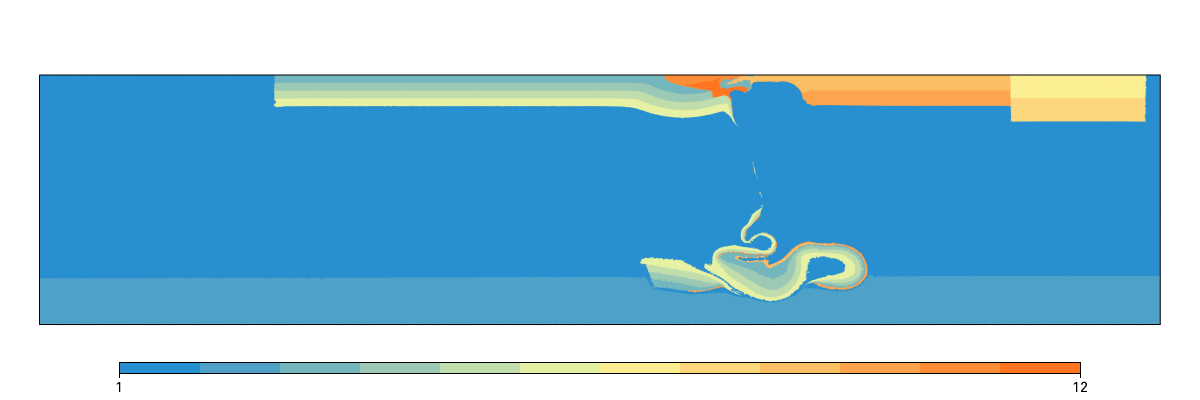

In [31]:
#Preview of 2D materials-Materials Field (from swarm)
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, Model.materialField,fn_size=2.0, discrete=True)
#Fig.Surface(Model.mesh,Model.projMaterialField,fn_size=2.0)
Fig.show()


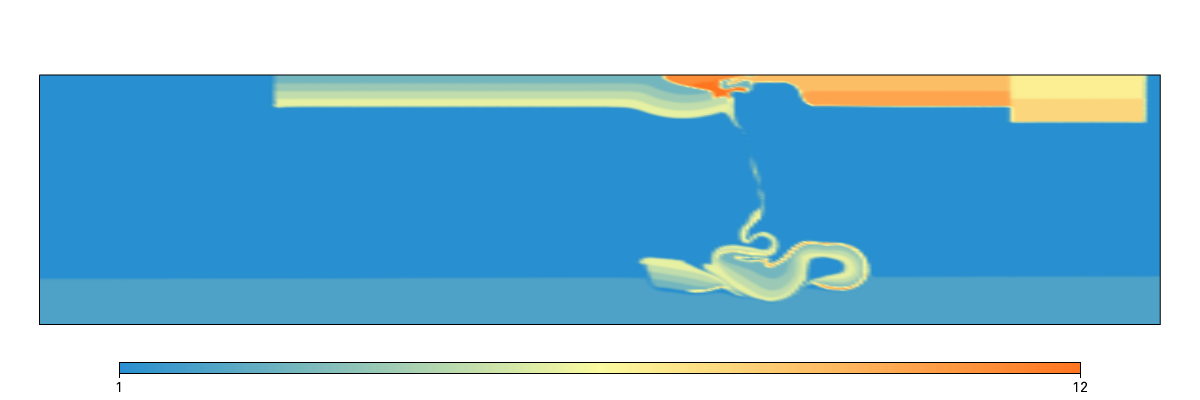

In [32]:
#Preview of 2D materials-Materials Field (from swarm)
Fig = glucifer.Figure(figsize=(1200,400))
#Fig.Points(Model.swarm, Model.materialField,fn_size=2.0, discrete=True)
Fig.Surface(Model.mesh,Model.projMaterialField,fn_size=2.0)
Fig.show()


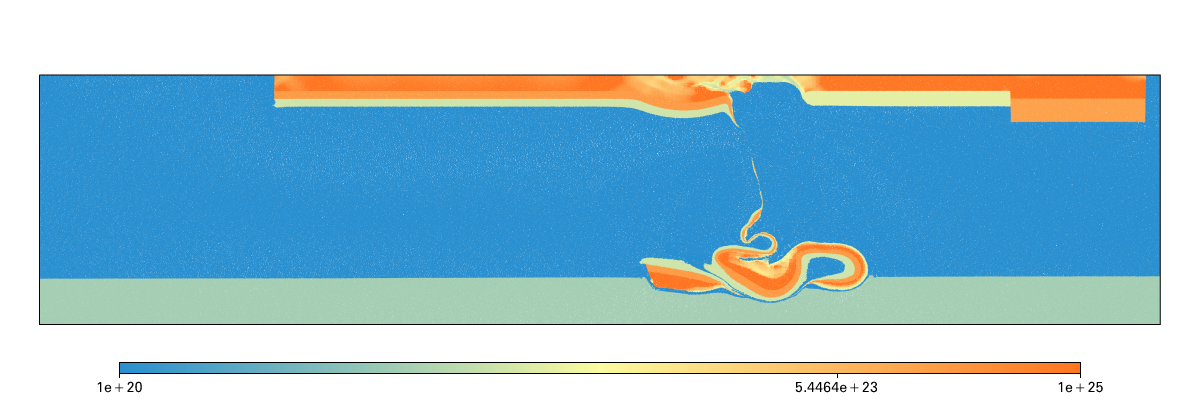

In [33]:
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, GEO.Dimensionalize(Model.viscosityField, u.pascal * u.second),logScale=True)
Fig.show()


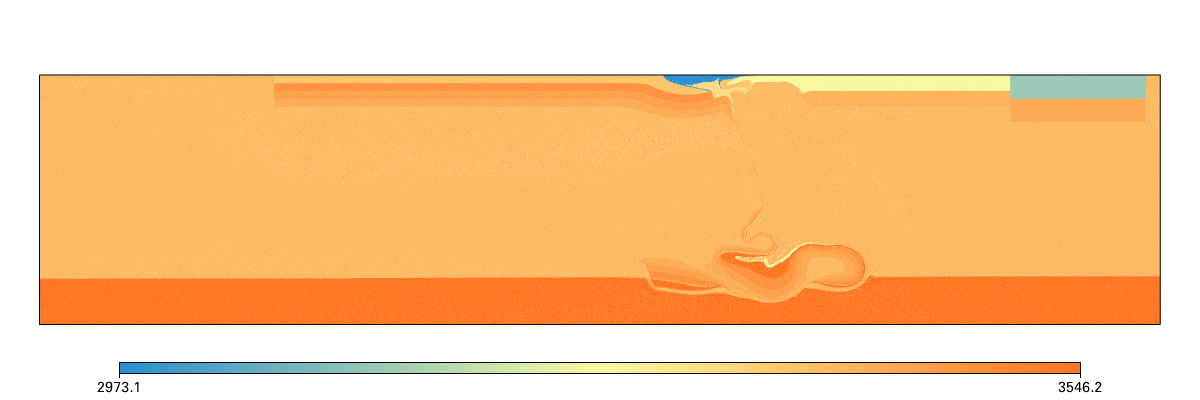

In [34]:
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, GEO.Dimensionalize(Model.densityField, u.kilogram / u.metre**3))
#Fig.Surface(Model.mesh, GEO.Dimensionalize(Model.projDensityField, u.kilogram / u.metre**3))
Fig.show()